In [33]:
import numpy as np
import scipy.stats as sps
import pandas as pd
import sympy as sym

import matplotlib.pyplot as plt

# 1
![](img/task1.png)

In [34]:
n = 30
lambd = 1

lambd_mle_bias = lambd * n / (n - 1) - lambd
lambd_mle_std = (lambd**2 * n**2 / ((n - 1)**2 * (n - 2)))**0.5
print(f'{lambd_mle_bias = }\n{lambd_mle_std = }')

data = np.random.exponential(lambd, size=(10**6, n))
lambd_mle_bias_mc = np.mean(1 / data.mean(-1)) - lambd
lambd_mle_std_mc = np.std(1 / data.mean(-1))
print(f'{lambd_mle_bias_mc = :.5f}\n{lambd_mle_std_mc = :.5f}')

lambd_mle_bias = 0.034482758620689724
lambd_mle_std = 0.1954988653496003
lambd_mle_bias_mc = 0.03453
lambd_mle_std_mc = 0.19533


In [35]:
n = sym.symbols(r'n', int=True, positive=True)
y = sym.symbols(r'y', nonnegative=True, real=True)
lambd = sym.symbols(r'\lambda', real=True, positive=True)

rho_gamma = y**(n-1) * lambd**n / sym.factorial(n - 1) * sym.exp(-lambd * y)

In [36]:
# bias
bias = (sym.integrate(n/y * rho_gamma, (y, 0, sym.oo)) - lambd).simplify()
bias.subs({n : 30, lambd : 1}).evalf()

0.0344827586206897

In [37]:
# std
((sym.integrate((n/y)**2 * rho_gamma, (y, 0, sym.oo)) - sym.integrate(n/y * rho_gamma, (y, 0, sym.oo))**2)**0.5).simplify().subs({n : 30, lambd : 1}).evalf()

0.195498865349600

# 2
![](img/task2.png)

In [38]:
data = np.array([(576, 3.39), (635, 3.30), (558, 2.81), (578, 3.03), (666, 3.44),
                 (580, 3.07), (555, 3.0), (661, 3.43), (651, 3.36), (605, 3.13),
                 (653, 3.12), (575, 2.74), (545, 2.76), (572, 2.88), (594, 2.96)])

In [39]:
def bootstrap_corr(sample, number_of_trials):
    size = len(sample)
    return np.array([np.corrcoef(sample[np.random.choice(size, size)], rowvar=False)[0, 1] for _ in range(number_of_trials)])

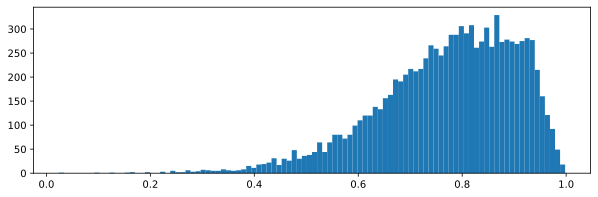

In [40]:
corrs = bootstrap_corr(data, 10000)

plt.figure(figsize=(10, 3))
plt.hist(corrs, bins=100)
plt.show()

# 3
![](img/task3_1.png)
![](img/task3_2.png)

In [41]:
def std_vanilla(n, w, mu_m, sigma2_m, mu_f, sigma2_f, number_of_trials):
    return np.sqrt((w * sigma2_m + (1 - w) * sigma2_f + w * (1 - w) * (mu_m - mu_f)**2) / n)

def std_weighted(n, w, mu_m, sigma2_m, mu_f, sigma2_f, number_of_trials):
    return np.sqrt((w * sigma2_m + (1 - w) * sigma2_f) / n)

In [42]:
n = 30
w = 0.86 / 1.86
mu_m, sigma2_m = 176, 6 ** 2
mu_f, sigma2_f = 165, 5 ** 2
number_of_trials = 10000

print(std_vanilla(n, w, mu_m, sigma2_m, mu_f, sigma2_f, number_of_trials),
      std_weighted(n, w, mu_m, sigma2_m, mu_f, sigma2_f, number_of_trials))

1.4161525731286333 1.0014326654910677


# 4
![](img/task4.png)

In [43]:
import sympy as sym

x_sym, theta_sym = sym.symbols(r'x \theta', real=True)
p_x_theta = 1 / (sym.pi * (1 + (x_sym - theta_sym)**2))
l_x_theta = sym.log(p_x_theta)
score_func = sym.diff(l_x_theta, theta_sym)
integrand_func = (score_func**2 * p_x_theta).simplify()
integrand_func_lambd = sym.lambdify((x_sym, theta_sym), integrand_func)
inv_fisher_inf = float((1/sym.integrate(integrand_func, (x_sym, -sym.oo, sym.oo))).evalf())

def integrand(x, theta):            
    return integrand_func_lambd(x, theta)

def answer():
    return inv_fisher_inf

In [44]:
integrand(0.42, -1.337)

0.05757369569474807

In [45]:
answer()

2.0

# 5
![](img/task5.png)

In [46]:
vk = pd.read_csv('https://stepik.org/media/attachments/lesson/1233589/vk_likes.csv')
vk = vk[(vk['VIEW'] > 0) & (vk['VIEW'] < 800)]

In [47]:
from scipy.optimize import minimize

def minus_log_posterior(x):
    a, b = x
    # реализовать функцию, которая возвращает -1 * (log p(x_[n] | theta) + log p(theta))
    return -1 * sps.betabinom.logpmf(k=vk.LIKE, n=vk.VIEW, a=a, b=b).sum() -2.5 * np.log(1 + a + b)

res = minimize(minus_log_posterior, x0=[1, 1], bounds=[(1e-5, None), (1e-5, None)])
a_MAP, b_MAP = res.x

In [48]:
def calc_observed_fisher_inf(a_MAP, b_MAP, h = 1e-3):
    minus_log_posterior_a_b = minus_log_posterior((a_MAP, b_MAP))
    minus_log_posterior_ah_b = minus_log_posterior((a_MAP + h, b_MAP))
    minus_log_posterior_a_bh = minus_log_posterior((a_MAP, b_MAP + h))
    d2J_da2 = (minus_log_posterior_ah_b - 2 * minus_log_posterior_a_b + minus_log_posterior((a_MAP - h, b_MAP)))/h**2
    d2J_db2 = (minus_log_posterior_a_bh - 2 * minus_log_posterior_a_b + minus_log_posterior((a_MAP, b_MAP - h)))/h**2
    dJ_dadb = (minus_log_posterior((a_MAP + h, b_MAP + h)) - minus_log_posterior_ah_b - minus_log_posterior_a_bh + minus_log_posterior_a_b)/h**2
    
    return np.array([
        [d2J_da2, dJ_dadb],
        [dJ_dadb, d2J_db2]
    ])

In [49]:
J = calc_observed_fisher_inf(a_MAP, b_MAP)
J

array([[38220.80751706, -1688.31809424],
       [-1688.31809424,    98.97409473]])

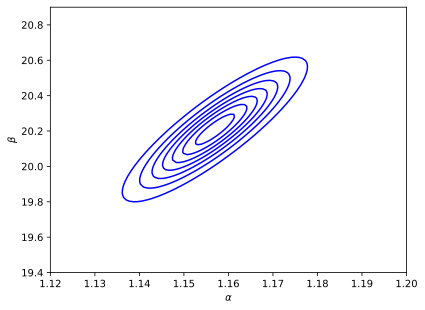

In [50]:

mu = [a_MAP, b_MAP]
cov = np.linalg.inv(J)
density = sps.multivariate_normal(mu, cov).pdf
x = np.linspace(1.12, 1.2, 100) 
y = np.linspace(19.4, 20.9, 100) 

X, Y = np.meshgrid(x, y)
XY = np.stack([X, Y], axis=-1)

plt.figure(dpi=150)
plt.contour(X, Y, density(XY), colors='blue')
plt.xlabel(r'$\alpha$'); plt.ylabel(r'$\beta$')
plt.show()

In [51]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
# магия для того, чтобы графики рисовались в векторном формате
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

model = pm.Model()

with model:
    alpha = pm.HalfNormal('alpha', sigma=10)
    beta = pm.HalfNormal('beta', sigma=10)
    likes = pm.BetaBinomial('likes', alpha=alpha, beta=beta, n=vk['VIEW'], observed=vk['LIKE'])

    trace = pm.sample(draws=10**3, nuts_sampler='numpyro')

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

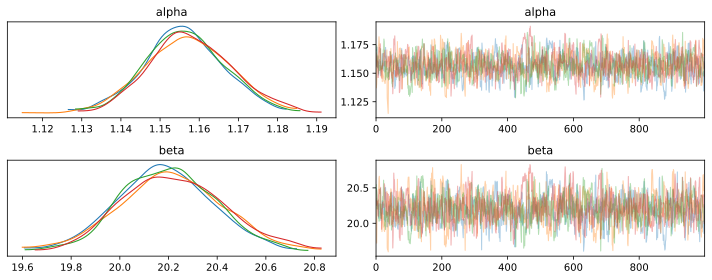

In [52]:
az.plot_trace(trace, var_names=['alpha', 'beta'], figsize = (10, 4), compact=False)
plt.tight_layout() # это чтобы графики не слипались
plt.show()

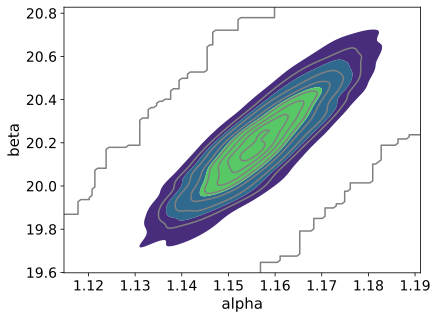

In [53]:
az.plot_pair(trace, var_names=['alpha', 'beta'], kind='kde')
plt.show()

Обратите внимание, насколько быстрее посчитать аппроксимацию нормальным распределением, чем сэмплировать с помощью pymc! 